In [1]:
%matplotlib notebook
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import time, requests, json
from decouple import config
import pandas as pd
import numpy as np
import bitmex
import enum

## Order Status Enum

In [2]:
# Using enum class create enumerations
class OrderStatus(enum.Enum):
    NO_ORDER = 1
    LONG = 2
    SHORT = 3
    SQUARE_OFF = 4

## Initialize Bitmex Client

A Good Resource to start using bitmex API
https://medium.com/coinmonks/a-bitmex-python-tutorial-5f3cdf2491a7

Bitmex Costs
https://hackernoon.com/a-quick-starter-guide-to-using-leveraged-trading-at-bitmex-5383de4cb320

In [3]:
bitmex_api_key = config('BITMEX_API_KEY')  # Enter your own API-key here
bitmex_api_secret = config('BITMEX_SECRET_KEY')  # Enter your own API-secret here
client = bitmex.bitmex(test = False, api_key=bitmex_api_key, api_secret=bitmex_api_secret) 

c:\python37\lib\site-packages\swagger_spec_validator\validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


## Variable ---

In [4]:
symbol1 = 'XBTUSD'
symbol2 = 'BCHUSD'

symbolcomposite = '.BBCHXBT'

data_count = 20000
bitmex_max_count = 1000
bin_size = '5m'

current_balance = starting_capital = 10000
algo_stop_balance = 0.1 * starting_capital

rolling_window = 150
sell_periods = 1

z_score_buy_threshold = -1
z_score_short_threshold = 1

transaction_fee = 0

leverage = 20

## Past Data Initializations

Read about https://www.bitmex.com/app/index/.BBCHXBT

In [5]:
def getHistoricalData(symbol,data_count):
    
    i_lim = np.ceil(data_count/bitmex_max_count)
    print("Getting Historical Data For " + symbol)
    for i in range(int(i_lim)-1,-1,-1):
        data_start_index = bitmex_max_count*i

#         print("Getting Data From Index " + str(data_start_index))

        past_data_list = reversed(
        client.Trade.Trade_getBucketed(
            binSize=bin_size,start=data_start_index ,count=bitmex_max_count, symbol=symbol, reverse=True
        ).result()[0])

        if(i == i_lim -1):
            past_dataframe_symbol = pd.DataFrame.from_records(past_data_list)
        else:
            past_dataframe_symbol = past_dataframe_symbol.append(
                pd.DataFrame.from_records(past_data_list),ignore_index=True)
        
    return past_dataframe_symbol

past_dataframe_symbol1 = getHistoricalData(symbol1,data_count)
past_dataframe_symbol2 = getHistoricalData(symbol2,data_count)
past_dataframe_symbolcomposite = past_dataframe_symbol1
# past_dataframe_symbolcomposite =getHistoricalData(symbolcomposite,data_count)

past_dataframe_symbol2.tail(1)

Getting Historical Data For XBTUSD
Getting Historical Data For BCHUSD


,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
19999,2021-01-02 09:10:00+00:00,BCHUSD,342.85,343.3,342.45,343.15,31,2439,342.93,70.0,83640295,72.8057,24967.16715


## Constructing a main dataframe

In [6]:
ticker_main = [past_dataframe_symbol1.close,past_dataframe_symbol2.close,
               past_dataframe_symbol2.close/past_dataframe_symbol1.close]
headers = [symbol1,symbol2,symbolcomposite]
ticker_main_df = pd.concat(ticker_main, axis=1, keys=headers)
ticker_main_df

,XBTUSD,BCHUSD,.BBCHXBT
0,13092.0,274.95,0.021001
1,13101.0,274.95,0.020987
2,13090.0,274.90,0.021001
3,13076.5,274.85,0.021019
4,13092.0,274.95,0.021001
...,...,...,...
19995,29912.0,343.05,0.011469
19996,29915.0,343.05,0.011467
19997,29939.5,342.75,0.011448
19998,29877.5,342.85,0.011475


## Plotting the Symbols

<IPython.core.display.Javascript object>


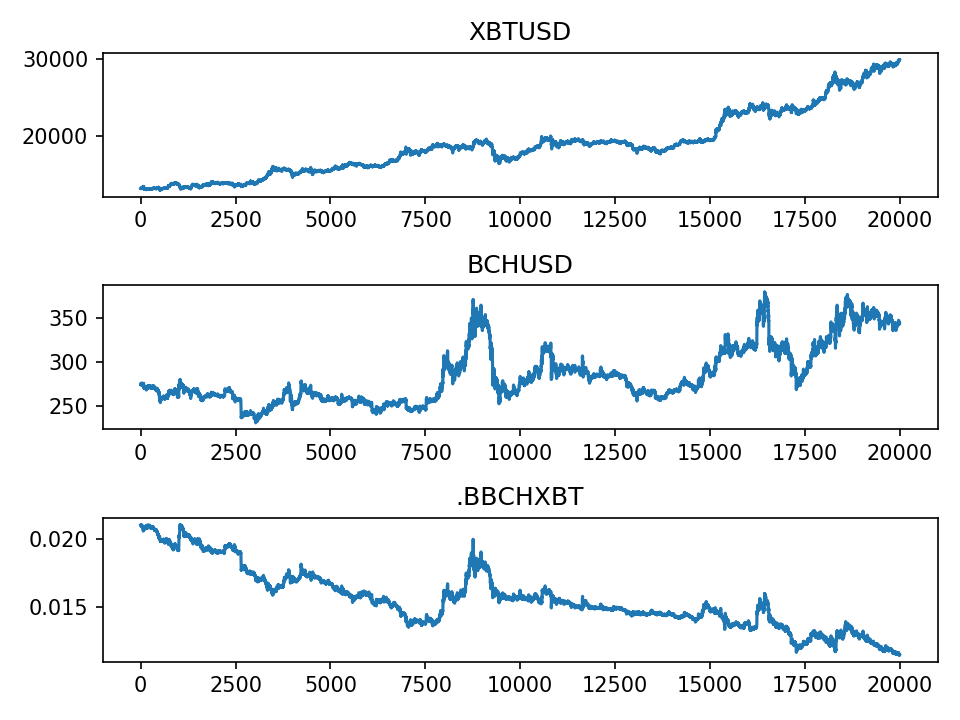

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1)

plt.subplot(3,1,1)
plt.plot(ticker_main_df[symbol1])
plt.title(symbol1)

plt.subplot(3,1,2)
plt.plot(ticker_main_df[symbol2])
plt.title(symbol2)

plt.subplot(3,1,3)
plt.plot(ticker_main_df[symbolcomposite])
plt.title(symbolcomposite)

fig.tight_layout()
plt.show()

## Regression Model for Hedge Ratio Calculation

In [8]:
ticker_main_df[symbol1 + '_log'] = np.log(ticker_main_df[symbol1])
ticker_main_df[symbol2 + '_log'] = np.log(ticker_main_df[symbol2])

regression_model = RollingOLS(ticker_main_df[symbol1 + '_log'], ticker_main_df[symbol2 + '_log'],rolling_window)
rolling_res = regression_model.fit()

ticker_main_df['Hedge_Ratio'] = rolling_res.params

ticker_main_df['Distance'] = ticker_main_df[symbol1 + '_log'] 
- (ticker_main_df['Hedge_Ratio'] * ticker_main_df[symbol2 + '_log'])

ticker_main_df['Mean_Dist'] = ticker_main_df['Distance'].rolling(rolling_window).mean()
ticker_main_df['Std_Dist'] = ticker_main_df['Distance'].rolling(rolling_window).std()

ticker_main_df['Z_Score'] = (ticker_main_df['Distance'] - ticker_main_df['Mean_Dist'])/(ticker_main_df['Std_Dist'])

In [9]:
ticker_main_df

,XBTUSD,BCHUSD,.BBCHXBT,XBTUSD_log,BCHUSD_log,Hedge_Ratio,Distance,Mean_Dist,Std_Dist,Z_Score
0,13092.0,274.95,0.021001,9.479757,5.616589,NaN,9.479757,NaN,NaN,NaN
1,13101.0,274.95,0.020987,9.480444,5.616589,NaN,9.480444,NaN,NaN,NaN
2,13090.0,274.90,0.021001,9.479604,5.616407,NaN,9.479604,NaN,NaN,NaN
3,13076.5,274.85,0.021019,9.478572,5.616225,NaN,9.478572,NaN,NaN,NaN
4,13092.0,274.95,0.021001,9.479757,5.616589,NaN,9.479757,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19995,29912.0,343.05,0.011469,10.306015,5.837876,1.763888,10.306015,10.291122,0.007061,2.109231
19996,29915.0,343.05,0.011467,10.306115,5.837876,1.763900,10.306115,10.291265,0.007146,2.078139
19997,29939.5,342.75,0.011448,10.306934,5.837001,1.763912,10.306934,10.291414,0.007238,2.144139
19998,29877.5,342.85,0.011475,10.304861,5.837293,1.763926,10.304861,10.291551,0.007297,1.824042


<IPython.core.display.Javascript object>


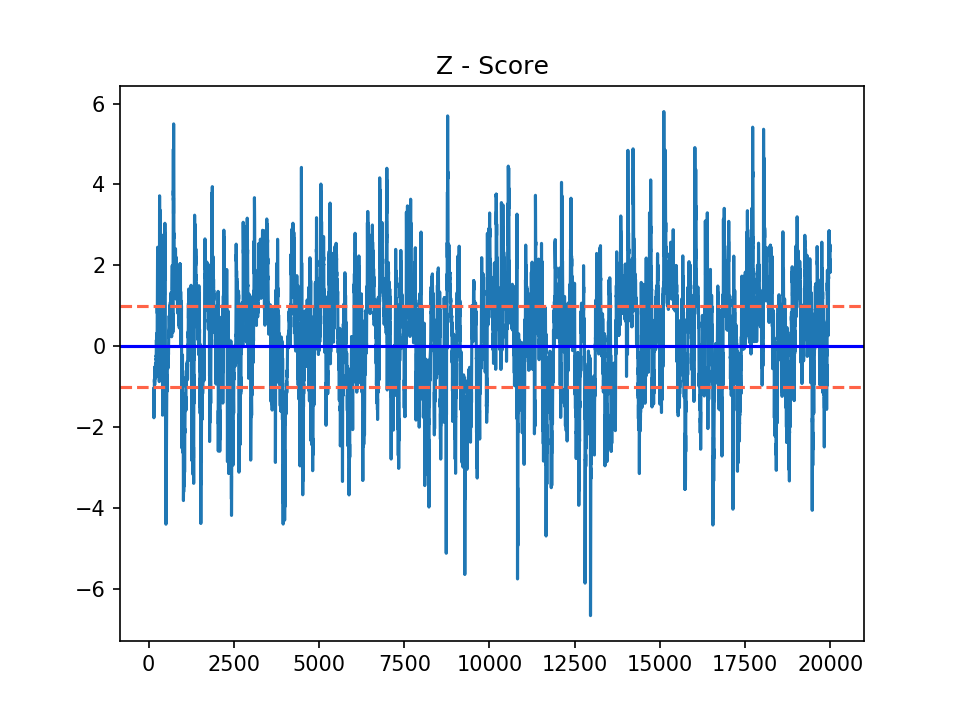

In [10]:
fig = plt.figure()
plt.plot(ticker_main_df['Z_Score'])
plt.axhline(y=0,color='b')
plt.axhline(y=z_score_buy_threshold,color='tomato',linestyle='--')
plt.axhline(y=z_score_short_threshold,color='tomato',linestyle='--')
plt.title("Z - Score")
plt.show()

In [11]:
open_orders = net_return = net_change = buy_price = short_price = counts = time_period = sell_price = 0
index_length = len(ticker_main_df)
balance_list = []
returns_list = []

## -------------------------------------------------------------------------------------------------------
order_status = OrderStatus.NO_ORDER
trade_count = 0

price_symbol1 = 0
price_symbol2 = 0

squareOff_price_symbol1 = 0
squareOff_price_symbol2 = 0

square_off_index = 0

In [12]:
for index,row in ticker_main_df.iterrows():
    #print(index)
    
    ## Price of 1st Asset
    current_price_symbol1 = row[symbol1]
    
    ## Price of 2nd Asset
    current_price_symbol2 = row[symbol2]
    
    ## Z Score at the moment
    z_score = row["Z_Score"]
    
    ## For a Valid Portfolio Balance
    if current_balance > algo_stop_balance:
        
        ## If there is no existing order in place, and Z-Score is below Buy Threshold!
        if(order_status == OrderStatus.NO_ORDER and z_score <= z_score_buy_threshold):
            ## Long Order Initialized
            #print('Long Order Initialized!')
            order_status = OrderStatus.LONG
            
            ## Increment Trade Count 
            trade_count = trade_count + 1
            
            ## Set Square off Condition
            square_off_index = index + sell_periods
            
            ## Long Symbol 1 and Short Symbol 2
            price_symbol1 = current_price_symbol1
            price_symbol2 = current_price_symbol2
            
            
        if(order_status == OrderStatus.NO_ORDER and z_score >= z_score_short_threshold):
            ## Short Order Initialized
            #print('Short Order Initialized!')
            order_status = OrderStatus.SHORT
            
            ## Increment Trade Count 
            trade_count = trade_count + 1
            
            ## Set Square off Condition
            square_off_index = index + sell_periods
            
            ## Short Symbol 1 and Long Symbol 2
            price_symbol1 = current_price_symbol1
            price_symbol2 = current_price_symbol2
        
        
        if(order_status != OrderStatus.NO_ORDER):
            
            ## Square off
            if(index == square_off_index):
                
                ## Update Square off prices
                squareOff_price_symbol1 = current_price_symbol1
                squareOff_price_symbol2 = current_price_symbol2
                
                ## Balance Allocation for Positions (inclusive of leverage)
                balance_alloc_symbol1 = 0.5  * leverage * current_balance
                balance_alloc_symbol2 = 0.5  * leverage * current_balance
                
                
                ##Long Square Off
                if(order_status == OrderStatus.LONG):
                    ## Buy Quantity (inclusive of Transaction Fee Deductions)
                    quantity_symbol1 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol1/price_symbol1))
                    ## Since Symbol2 is Shorted its Buy quantity is calcualted based on the squareoff price
                    quantity_symbol2 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol2/squareOff_price_symbol2))
                    
                    ## Balance after Square Off i.e Selling the bought quantity
                    squareOff_bal_symbol1 = ((1 - transaction_fee) 
                                             * (squareOff_price_symbol1 * quantity_symbol1))/leverage

                    squareOff_bal_symbol2 = ((1 - transaction_fee) 
                                             * (price_symbol2 * quantity_symbol2))/leverage
                    
                ##Short Square Off
                if(order_status == OrderStatus.SHORT):
                    ## Buy Quantity (inclusive of Transaction Fee Deductions)
                    ## Since Symbol2 is Shorted its Buy quantity is calcualted based on the squareoff price
                    quantity_symbol1= ((1 - transaction_fee) 
                                        * (balance_alloc_symbol1/squareOff_price_symbol1))
                    
                    quantity_symbol2 = ((1 - transaction_fee) 
                                        * (balance_alloc_symbol2/price_symbol2))
                    
                    
                    ## Balance after Square Off i.e Selling the bought quantity
                    squareOff_bal_symbol1 = ((1 - transaction_fee) 
                                             * (price_symbol1 * quantity_symbol1))/leverage
                    
                    squareOff_bal_symbol2 = ((1 - transaction_fee) 
                                             * (squareOff_price_symbol2 * quantity_symbol2))/leverage

                    
                
                #print('Order Squares Off!')
                resultant_balance = squareOff_bal_symbol1 + squareOff_bal_symbol2
                
                current_balance = resultant_balance
                order_status = OrderStatus.NO_ORDER
        balance_list.append(current_balance)
                

print(trade_count)
print(current_balance)

5258
11334.648094748416


In [13]:
def oldCode():
    for index,row in ticker_main_df.iterrows():
        current_price = row[symbolcomposite]
        z_score = row["Z_Score"]

        if current_balance > 0.1 and counts < (index_length - sell_periods):

            if open_orders == 1 and counts == time_period:

                sell_price = current_price
                net_return = (sell_price / buy_price)
                net_change = (sell_price - buy_price) / buy_price
                fees = (1-transaction_fee) * net_return
                current_balance = current_balance * fees
                returns_list.append(net_change)
                open_orders = 0

            if open_orders == 2 and counts == time_period:

                sell_price = current_price
                net_return = (short_price / sell_price)
                net_change = (short_price - sell_price) / short_price
                fees = (1-transaction_fee) * net_return
                current_balance = current_balance * fees
                returns_list.append(net_change)
                open_orders = 0

            if open_orders == 0 and z_score <= z_score_buy_threshold:
                short_price = current_price
                open_orders = 2
                time_period = counts + sell_periods

            if open_orders == 0 and z_score >= z_score_short_threshold:
                buy_price = current_price
                open_orders = 1
                time_period = counts + sell_periods

            #print(counts, "Balance " + str(current_balance), "Buy Price " + str(buy_price),
            #    "Sell Price "+ str(sell_price), "Net Return " + str(net_return))

        balance_list.append(current_balance)
        counts = counts +1

<IPython.core.display.Javascript object>


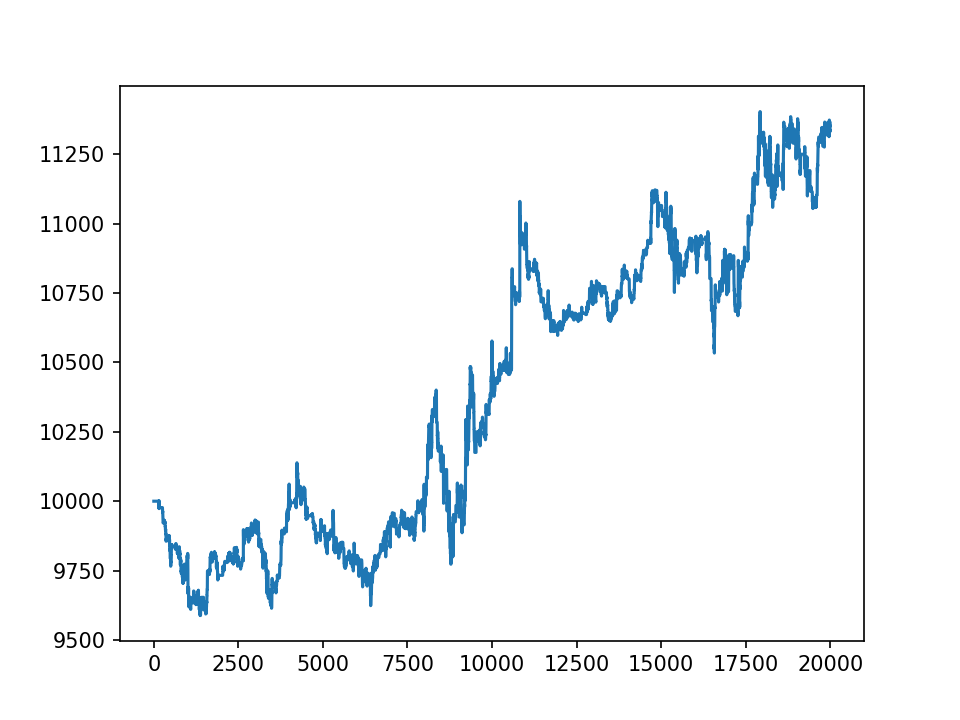

In [14]:
fig = plt.figure()
plt.plot(balance_list)
plt.show()

In [15]:
current_balance

11334.648094748416